In [35]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [283]:
import gym
import numpy as np
import RNA

In [40]:
gym.spaces.MultiDiscrete([4, 4])

MultiDiscrete([4 4])

In [ ]:
gym.spaces.MultiDiscrete()

In [284]:
from RNA_helper import get_initial_guess, bracket_to_bonds, secundary_structures_metric

In [164]:
def bracket_to_bonds_and_singles(structure):
    bond_tuples = []
    opening = []
    singles = []
    for i,c in enumerate(structure):
        if c == '(':
            opening.append(i)
        elif c == ')':
            j = opening.pop()
            assert j < i
            bond_tuples.append((j, i))
        elif c == '.':
            singles.append(i)
        else:
            # No debería entrar
            assert False
    assert len(singles) +  2*len(bond_tuples) == len(structure)
    return bond_tuples, singles

In [356]:
class RNAInvEnvironment(gym.Env):
    def __init__(self, objective_structure, policy='random', max_steps=100):
        self.pairs_list = np.array(['CG', 'GC', 'AU', 'UA', 'GU', 'UG'])
        self.bases_list = np.array(['G', 'U', 'A', 'C'])
        self.N_pairs = len(self.pairs_list)
        self.N_bases = len(self.bases_list)
        self.objective_structure = objective_structure
        self.N = len(objective_structure)
        self.bonds = bracket_to_bonds(objective_structure)
        self.bond_tuples, self.singles = bracket_to_bonds_and_singles(objective_structure)
        self.pairs_count = len(self.bond_tuples)
        self.single_count = len(self.singles)
        self.action_space = gym.spaces.MultiDiscrete([self.N_pairs]*self.pairs_count + [self.N_bases]*self.single_count)
        self.observation_space = gym.spaces.Tuple(
            tuple([gym.spaces.Discrete(self.N_bases) if i is None else gym.spaces.Discrete(self.N_pairs) for i in self.bonds])
        )
        self.max_steps = max_steps

    def action_to_state(self, action):
        pair_predictions = self.pairs_list[action[:self.pairs_count]]
        single_predictions = self.bases_list[action[self.pairs_count:]]
        output = [None]*self.N
        for k, (i, j) in enumerate(rna_inv_env.bond_tuples):
            output[i] = pair_predictions[k][0]
            output[j] = pair_predictions[k][1]
        for k, i in enumerate(self.singles):
            output[i] = single_predictions[k]
        return ''.join(output)
    
    def sample_random_action(self):
        action = self.action_space.sample()
        return self.action_to_state(action)
        
    
    def reset(self):
#         self.state = get_initial_guess(self.objective_structure, 'low_energy_bonds')
        self.state = self.sample_random_action()
        self.steps = 0
        return self.state
    
    def step(self, action):
        self.steps = self.steps + 1
        self.state = self.action_to_state(action)
        current_structure, energy = RNA.fold(self.state)
        done = (current_structure == self.objective_structure) or (self.steps >= self.max_steps)
        reward = secundary_structures_metric(current_structure, self.objective_structure)
        return self.state, reward, done, None

In [389]:
objective_structure = '(((((((((((((((.(((((.((.....)).((.....)).((.....)).((.....)).((.....)).))))).(((.....))).(((((.((.....)).((.....)).((.....)).((.....)).((.....)).))))).(((.....))).(((((.((.....)).((.....)).((.....)).((.....)).((.....)).))))).(((.....))).(((((.((.....)).((.....)).((.....)).((.....)).((.....)).))))).(((.....))).(((((.((.....)).((.....)).((.....)).((.....)).((.....)).))))).)))))))))))))))'
# objective_structure = '(((((......)))))'

In [390]:
rna_inv_env = RNAInvEnvironment(objective_structure)

In [391]:
done = False
obs = rna_inv_env.reset()
print(obs)
rewards = []
while not done:
    action = rna_inv_env.action_space.sample()
    obs, reward, done, _ = rna_inv_env.step(action)
    rewards.append(reward)

GGUUACGAGCGAAGGGGGCCGGGGUGCGUCUUCUCUUGUAGUGUCUCUAGCCUGGCUUACAACUUAAUAAGCUGGCCGUUGCCAUGUGGCUGGUACUCCUUUCGGGCUCGUAGGGCGUAGUCUACGUUGUGCAAGUCUGUCAAAGAUACUAUUGGCAUUGCCGUGUUACAGGACGAACCCUGAUGCACGGACCCCGCGUUCUGCUUGAGCAUCGUUUGUUGUGGCCGUCAAUGAGAUGACCAGAAUGUUUCAUUUUUUGAAGAACGUGAAACGCAUCUUUGAUAUAAUGUAUGUUUGGUUGGAGUCAUUUUUGUGUUGUUGAAGUGAGUGCAGGCUAUUCUUUUGGGUUUUGGAAGGCCCAUAACGGUGGUAUUUUUUCGCUUGUAAUU


In [392]:
from matplotlib import pyplot as plt

In [394]:
# rewards, done

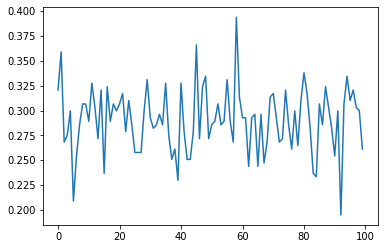

In [395]:
plt.plot(rewards)

In [295]:
rna_inv_env.sample_random_action()

'CCACACUCAGAAGUGAUAACGACAUUUACUGCCGAGAUCCGUUGCAACAUAUCUAUACAGGAUCCGGCAGGUCGUUAGCGCCCAGUGUGGCUUGUGGAGGCAGUCAGGGACUAUCGGUGCAUGGUCGGCUGAGCUCUUUUUGGGGGACAAGAACUUUGAAAGUUGGUUUUCUGGCAGAGAUUUUGGGAAGGUCCCGAGCCACCCAGUGUCGUGCUAUACGGGGCCCUGUAGGUCACACGUGUGCCGCCCAGCGCGCCAUACGUCGUAUUAUGCCUUAGUAGAACCUGACAAAGGCGUAUACGUAAGGUAUGAGUUGACUUUCUGGAAAUUGACAGAAGUGCUGUAUGGUUACUGAAAUUGGAACACACUCAAUAUAUUUUUGGGUGUGG'

In [190]:
rna_inv_env.action_space.shape

(287,)

In [196]:
actions = rna_inv_env.action_space.sample()

In [205]:
sampled = list(rna_inv_env.pairs_list[actions[:rna_inv_env.pairs_count]]) + list(rna_inv_env.bases_list[actions[rna_inv_env.pairs_count:]])

In [207]:
print(sampled)

['GC', 'UA', 'UG', 'GC', 'UA', 'AU', 'UG', 'AU', 'UG', 'AU', 'AU', 'AU', 'CG', 'UG', 'UA', 'GU', 'GU', 'CG', 'CG', 'CG', 'AU', 'GU', 'GU', 'GU', 'GU', 'GU', 'UA', 'UG', 'AU', 'GU', 'GU', 'GU', 'AU', 'GC', 'UA', 'UG', 'CG', 'CG', 'GU', 'CG', 'CG', 'GC', 'AU', 'GU', 'GU', 'GU', 'UG', 'CG', 'GC', 'GC', 'AU', 'UA', 'UG', 'GU', 'GU', 'UG', 'AU', 'CG', 'UG', 'UA', 'UA', 'AU', 'UA', 'GC', 'UG', 'UG', 'UG', 'UA', 'AU', 'UA', 'AU', 'AU', 'UG', 'AU', 'AU', 'GU', 'GU', 'CG', 'AU', 'CG', 'AU', 'GC', 'GU', 'GU', 'GU', 'AU', 'UA', 'CG', 'UG', 'GC', 'GC', 'AU', 'GU', 'AU', 'AU', 'GU', 'UG', 'UA', 'GU', 'UA', 'UG', 'UG', 'A', 'U', 'G', 'A', 'A', 'G', 'U', 'C', 'G', 'G', 'U', 'C', 'C', 'U', 'A', 'G', 'A', 'G', 'U', 'A', 'C', 'G', 'G', 'A', 'C', 'A', 'G', 'U', 'U', 'U', 'C', 'U', 'C', 'U', 'G', 'G', 'U', 'A', 'G', 'A', 'C', 'U', 'G', 'U', 'G', 'A', 'C', 'U', 'G', 'U', 'C', 'A', 'C', 'C', 'U', 'G', 'G', 'C', 'C', 'G', 'C', 'A', 'U', 'G', 'U', 'G', 'A', 'U', 'G', 'U', 'C', 'A', 'C', 'G', 'A', 'C', 'A', 'G

In [221]:
# output

In [214]:

pair_predictions

array(['GC', 'UA', 'UG', 'GC', 'UA', 'AU', 'UG', 'AU', 'UG', 'AU', 'AU',
       'AU', 'CG', 'UG', 'UA', 'GU', 'GU', 'CG', 'CG', 'CG', 'AU', 'GU',
       'GU', 'GU', 'GU', 'GU', 'UA', 'UG', 'AU', 'GU', 'GU', 'GU', 'AU',
       'GC', 'UA', 'UG', 'CG', 'CG', 'GU', 'CG', 'CG', 'GC', 'AU', 'GU',
       'GU', 'GU', 'UG', 'CG', 'GC', 'GC', 'AU', 'UA', 'UG', 'GU', 'GU',
       'UG', 'AU', 'CG', 'UG', 'UA', 'UA', 'AU', 'UA', 'GC', 'UG', 'UG',
       'UG', 'UA', 'AU', 'UA', 'AU', 'AU', 'UG', 'AU', 'AU', 'GU', 'GU',
       'CG', 'AU', 'CG', 'AU', 'GC', 'GU', 'GU', 'GU', 'AU', 'UA', 'CG',
       'UG', 'GC', 'GC', 'AU', 'GU', 'AU', 'AU', 'GU', 'UG', 'UA', 'GU',
       'UA', 'UG', 'UG'], dtype='<U2')

In [218]:


single_predictions

array(['A', 'U', 'G', 'A', 'A', 'G', 'U', 'C', 'G', 'G', 'U', 'C', 'C',
       'U', 'A', 'G', 'A', 'G', 'U', 'A', 'C', 'G', 'G', 'A', 'C', 'A',
       'G', 'U', 'U', 'U', 'C', 'U', 'C', 'U', 'G', 'G', 'U', 'A', 'G',
       'A', 'C', 'U', 'G', 'U', 'G', 'A', 'C', 'U', 'G', 'U', 'C', 'A',
       'C', 'C', 'U', 'G', 'G', 'C', 'C', 'G', 'C', 'A', 'U', 'G', 'U',
       'G', 'A', 'U', 'G', 'U', 'C', 'A', 'C', 'G', 'A', 'C', 'A', 'G',
       'C', 'G', 'U', 'C', 'C', 'U', 'U', 'U', 'C', 'U', 'G', 'U', 'G',
       'A', 'G', 'U', 'G', 'C', 'G', 'U', 'A', 'G', 'G', 'G', 'C', 'U',
       'C', 'G', 'A', 'G', 'C', 'A', 'C', 'C', 'C', 'C', 'C', 'U', 'C',
       'C', 'G', 'C', 'C', 'G', 'C', 'A', 'A', 'U', 'A', 'G', 'G', 'G',
       'A', 'C', 'A', 'U', 'U', 'G', 'G', 'C', 'G', 'U', 'A', 'G', 'G',
       'C', 'A', 'C', 'G', 'A', 'U', 'G', 'A', 'U', 'C', 'C', 'A', 'U',
       'G', 'A', 'G', 'U', 'A', 'U', 'U', 'A', 'G', 'A', 'C', 'U', 'A',
       'A', 'C', 'U', 'C', 'A', 'G', 'U', 'U', 'A', 'A', 'A', 'C

In [116]:
print(rna_inv_env.observation_space.sample())

(0, 2, 1, 3, 4, 5, 0, 2, 3, 4, 0, 3, 0, 5, 1, 3, 4, 4, 4, 3, 3, 2, 4, 2, 0, 3, 3, 0, 2, 5, 5, 2, 1, 0, 3, 2, 2, 3, 0, 5, 0, 0, 2, 0, 0, 2, 0, 0, 3, 5, 5, 1, 0, 2, 2, 2, 2, 2, 0, 3, 3, 1, 0, 1, 3, 0, 0, 0, 0, 1, 1, 0, 5, 2, 1, 2, 2, 1, 5, 3, 0, 3, 2, 2, 3, 2, 1, 0, 0, 1, 5, 4, 5, 3, 4, 2, 5, 0, 2, 0, 2, 0, 0, 3, 1, 2, 4, 0, 2, 3, 0, 3, 3, 1, 2, 3, 0, 0, 1, 2, 2, 0, 2, 1, 5, 2, 4, 4, 1, 1, 3, 2, 3, 4, 2, 2, 1, 0, 1, 1, 3, 1, 2, 1, 3, 0, 1, 2, 2, 0, 0, 3, 2, 2, 5, 0, 2, 2, 0, 1, 2, 2, 3, 2, 0, 5, 3, 5, 4, 1, 4, 3, 2, 0, 2, 0, 1, 4, 2, 1, 3, 0, 2, 3, 0, 0, 3, 4, 2, 0, 1, 3, 3, 3, 1, 2, 0, 3, 3, 1, 1, 4, 1, 2, 0, 1, 0, 1, 1, 1, 4, 0, 0, 3, 1, 3, 3, 3, 3, 0, 5, 0, 3, 1, 2, 0, 5, 5, 4, 3, 3, 2, 3, 2, 3, 1, 2, 3, 4, 3, 0, 4, 4, 0, 5, 3, 2, 0, 3, 2, 0, 2, 0, 1, 2, 4, 1, 1, 2, 3, 0, 2, 5, 2, 1, 2, 1, 1, 2, 0, 1, 2, 4, 1, 0, 0, 0, 0, 3, 1, 2, 5, 3, 1, 2, 4, 2, 0, 3, 3, 0, 3, 2, 1, 0, 0, 0, 0, 0, 3, 3, 5, 5, 3, 3, 0, 2, 1, 4, 2, 3, 2, 2, 5, 3, 2, 2, 0, 4, 3, 2, 0, 0, 2, 3, 3, 5, 0, 5, 0, 0, 0, 3, 

In [161]:
bond_tuples, singles = bracket_to_bonds_and_singles(objective_structure)

In [208]:
# bond_tuples
singles

[15,
 21,
 24,
 25,
 26,
 27,
 28,
 31,
 34,
 35,
 36,
 37,
 38,
 41,
 44,
 45,
 46,
 47,
 48,
 51,
 54,
 55,
 56,
 57,
 58,
 61,
 64,
 65,
 66,
 67,
 68,
 71,
 77,
 81,
 82,
 83,
 84,
 85,
 89,
 95,
 98,
 99,
 100,
 101,
 102,
 105,
 108,
 109,
 110,
 111,
 112,
 115,
 118,
 119,
 120,
 121,
 122,
 125,
 128,
 129,
 130,
 131,
 132,
 135,
 138,
 139,
 140,
 141,
 142,
 145,
 151,
 155,
 156,
 157,
 158,
 159,
 163,
 169,
 172,
 173,
 174,
 175,
 176,
 179,
 182,
 183,
 184,
 185,
 186,
 189,
 192,
 193,
 194,
 195,
 196,
 199,
 202,
 203,
 204,
 205,
 206,
 209,
 212,
 213,
 214,
 215,
 216,
 219,
 225,
 229,
 230,
 231,
 232,
 233,
 237,
 243,
 246,
 247,
 248,
 249,
 250,
 253,
 256,
 257,
 258,
 259,
 260,
 263,
 266,
 267,
 268,
 269,
 270,
 273,
 276,
 277,
 278,
 279,
 280,
 283,
 286,
 287,
 288,
 289,
 290,
 293,
 299,
 303,
 304,
 305,
 306,
 307,
 311,
 317,
 320,
 321,
 322,
 323,
 324,
 327,
 330,
 331,
 332,
 333,
 334,
 337,
 340,
 341,
 342,
 343,
 344,
 347,
 350,
 351

In [151]:
len(objective_structure)

389

In [ ]:
pair_action_to_sequence = {}
{i: (i, j) for i, j in enumerate(rna_inv_env.bonds)}

In [136]:
np.array(rna_inv_env.bonds) != None

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True, False,  True,  True, False, False, False,
       False, False,  True,  True, False,  True,  True, False, False,
       False, False, False,  True,  True, False,  True,  True, False,
       False, False, False, False,  True,  True, False,  True,  True,
       False, False, False, False, False,  True,  True, False,  True,
        True, False, False, False, False, False,  True,  True, False,
        True,  True,  True,  True,  True, False,  True,  True,  True,
       False, False, False, False, False,  True,  True,  True, False,
        True,  True,  True,  True,  True, False,  True,  True, False,
       False, False, False, False,  True,  True, False,  True,  True,
       False, False, False, False, False,  True,  True, False,  True,
        True, False, False, False, False, False,  True,  True, False,
        True,  True,